# GAN: Adding Monet Painting Style to Regular Images
- Author: Tim Seidel
- Date: 28.07.2025
### I'm Something of a Painter Myself Kaggle Competition
The following notebook aims to train a CycleGAN on regular and monet images to then generate 7000 monet-style images. It consists of the following sections:

1. Providing a description of the problem & data, 
2. Developing an Exploratory Data Analysis, 
3. Building and analyzing the model architecture 
4. Performing hyperparameter tuning on the architecture & showing / analyzing results
5. Training CycleGan using Tuned Values
6. Generating 7000 Monet-Style Image
7. Providing a discussion and conclusion. 

### Github Repository: 
https://github.com/tseidel0509/Deep_Learning/blob/main/...


### Data Source: 
As part of this project data will be used from the I'm Something of a Painter Myself Kaggle Project. Specifically, I would like to cite: 
- https://www.kaggle.com/c/gan-getting-started


## Step 1: Description of Problem, GANs, and Data
#### Step 1.1 Problem Description: 
The goal is to build a GAN that generates 7000 Monet-style images. Specifically, the submission shall consist of 7000 images in jpg format of sizes 256x256x3 (RGB). The images shall be zipped and the output shall only have one output named images.zip.

The submission will be evaluated based on the MiFID (Memorization-informed Fréchet Inception Distance) score. A smaller score indicates better images.

A description of MiFID can be found here: https://www.kaggle.com/c/gan-getting-started

#### Step 1.2 GAN Description: 
GANs are a class of deep learning models that generate data by pitting two neural networks against each other in a zero-sum game. The generator, which creates fake data, and a discriminator, which evaluates whether the data is real or fake. Via this adversarial process, the generator learns to produce increasingle convincing output until the discriminator can no longer reliably tell the difference. In the case of a CycleGAN the generator takes as input the real data and produces a synthetic output which is then classified by the discrimator. 

#### Step 1.3 Data Description: 
The dataset consists of four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. For the purpose of this model the jpg images shall be using. The monet directory contains images of the monet paintings. The photo directory contains regular images. 

- monet_jpg: contains 300 images of Monet paintings sized 256x256 in JPEG format
- photo_jpg: contains 7038 regular images sized 256x256 in JPEG format

In [12]:
import os, zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import random
from tensorflow.keras.models import load_model

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

### Basic Configuration, Paths, and Hyperparameters 

In [3]:
MONET_DIR = "/kaggle/input/gan-getting-started/monet_jpg"
PHOTO_DIR = PHOTO_DIR = "/kaggle/input/gan-getting-started/photo_jpg"
OUTPUT_DIR = "/kaggle/working/images"
ZIP_PATH = "/kaggle/working/images.zip"

IMG_SIZE = 256
JITTER_SIZE = 286
EPOCHS = 50
BATCH_SIZE = 1
LR = 2e-4
BETA1 = 0.5
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 0.5*LAMBDA_CYCLE
NUM_TO_GENERATE = 7000

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
print("TF: ", tf.__version__, "GPUs: ", tf.config.list_physical_devices("GPU"))

TF:  2.18.0 GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Could not set memory growth:", e)

## Step 2: Exploratory Data Analysis
"Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?"

### Step 2.1: Basic Metrics

In [5]:
# Number of images
monet_images = sorted(glob(os.path.join(MONET_DIR, "*.jpg")))
photo_images = sorted(glob(os.path.join(PHOTO_DIR, "*.jpg")))
print(f"Number of Monet's: {len(monet_images)}, Number of Regular Images: {len(photo_images)}")

Number of Monet's: 300, Number of Regular Images: 7038


### Step 2.2: Display Samples of Monet's and Regular Images

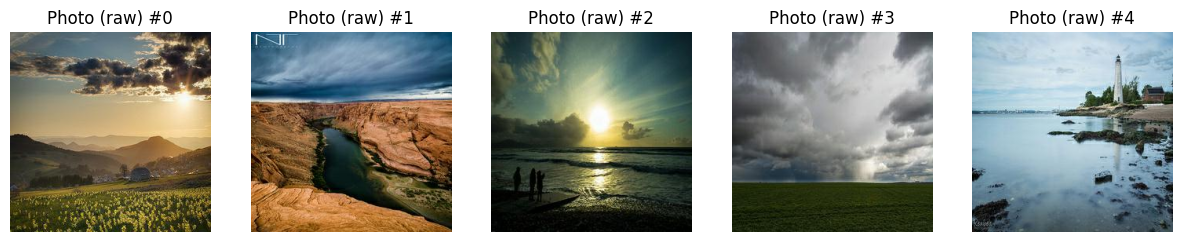

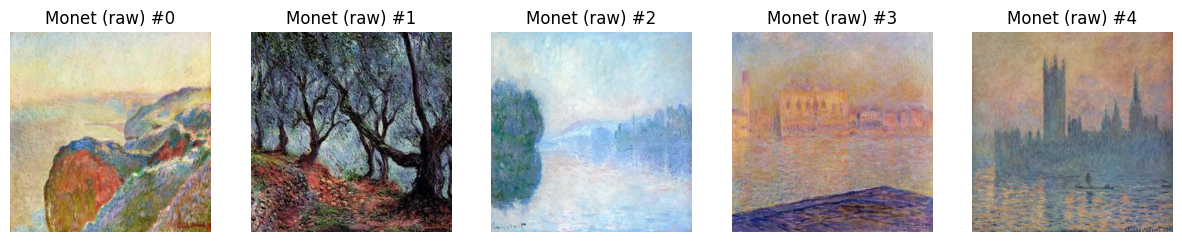

In [6]:
def show_images(paths, title, num = 5):
    plt.figure(figsize=(15,3))
    for i, path in enumerate(paths[:num]):
        img = Image.open(path)
        ax = plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title} #{i}")
    plt.show()

show_images(photo_images, "Photo (raw)", num = 5)
show_images(monet_images, "Monet (raw)", num = 5)

### Step 2.3: Display a Brightness Histogram
This helps us understand if there exists a domain shift between the regular images and the images of Monet paintings. Understanding the shift is critical for GANs. 

##### Benefits of a Brightness Histogram:
- Identify Domain Shift: if the Monet images are consistently darker or lighter a histogram will show the difference. This could imply a challenge for the generator and justify further preprocessing such as contrast augmentation.
- Assess Contrast and Dynamic Range:a wide spread in values indicates high contrast and would help decide whether to include contrast augmentaiton or normalization. 

I0000 00:00:1753791916.241657      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


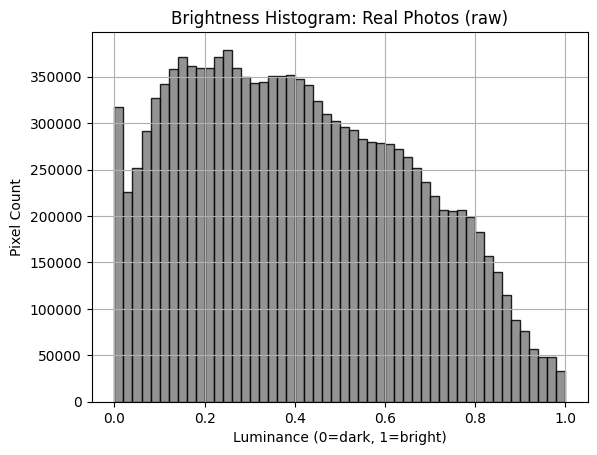

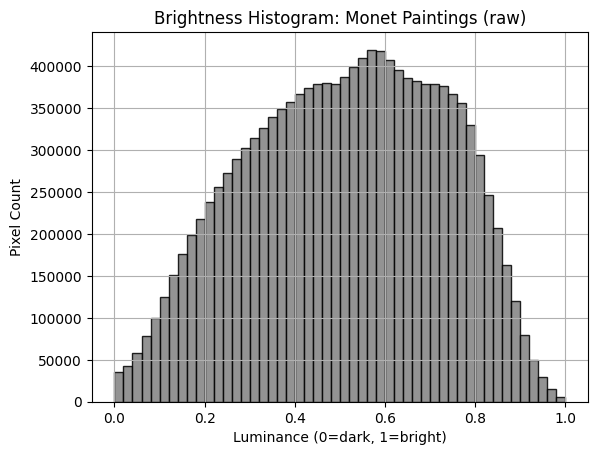

In [8]:
def brightness_histogram(paths, title, num=100):
    """
    Plot histograms of pixel brightness (luminance) for a subset of images.
    """
    all_pixels = []
    for path in paths[:num]:
        img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        img = tf.image.convert_image_dtype(tf.convert_to_tensor(img), tf.float32)
        pixels = tf.reshape(img, [-1,3])
        # Perceptual Brightness
        brightness = tf.tensordot(pixels, tf.constant([0.299, 0.587, 0.114]), axes = 1)
        all_pixels.extend(brightness.numpy())

    plt.hist(all_pixels, bins =50, alpha = 0.85, color = "gray", edgecolor = "black")
    plt.title(f"Brightness Histogram: {title}")
    plt.xlabel("Luminance (0=dark, 1=bright)")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.show()

brightness_histogram(photo_images, "Real Photos (raw)", num=200)
brightness_histogram(monet_images, "Monet Paintings (raw)", num=200)

##### Histogram Interpreation/Analysis: 
- Real: The histogram is left-skewed (i.e. more pixels have lower luminance. Peak brightness is in the 0.1-0.4 range. Hence the real images contain many dark to midtone regions.
- Monet: The histogram shows a gaussian distribution (i.e. bell shaped) and is centered around 0.5-0.6. Hence, the paintings have fewer extreme dark and light regions and the tone is more uniform.

Hence the generator (from real to Monet) must learn to increase overall brightness, reduce contrast and suppress very dark pixels. 

### Step 2.4: Plot the Color Distribution in RGB Channels
Visualizes how the color usage differs between the domains. 

##### Benefits of RGB Channel Distributions:
- Identify Color Shifts the Generator Must Learn: helps identify which channels need amplification or suppression and can provide tangible learning targets for the generator
- Detect Palette Difference: photos often have natural color balances whereas the paintings use more artistic palettes. 

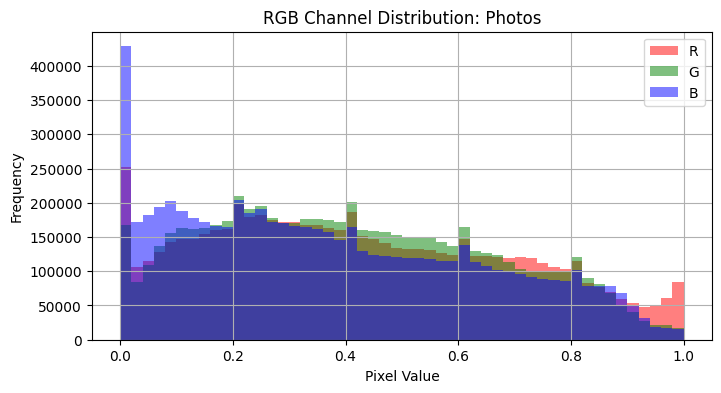

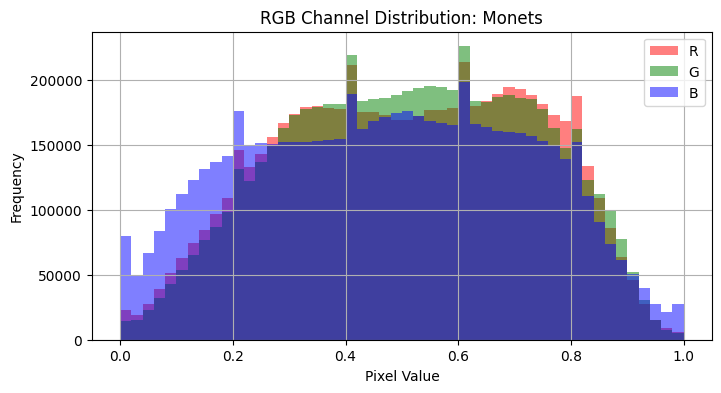

In [9]:
def plot_rgb_histogram(paths, title, num = 100):
    r_vals, g_vals, b_vals = [], [], []
    for path in paths[:num]:
        img = Image.open(path).resize((IMG_SIZE, IMG_SIZE))
        img = tf.image.covert_image_dtype(tf.convert_to_tensor(img), tf.float32).numpy()
        r, g, b = img[..., 0].flatten(), img[..., 1].flatten(), img[..., 2].flatten()
        r_vals.extend(r)
        g_vals.extend(g)
        b_vals.extend(b)

    plt.figure(figsize=(8,4))
    plt.hist(r_vals, bins = 50, alpha = 0.5, color = "red", label="R")
    plt.hist(g_vals, bins = 50, alpha = 0.5, color = "green", label="G")
    plt.hist(b_vals, bins = 50, alpha = 0.5, color = "blue", label="B")
    plt.title(f"RGB Channel Distribution: {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rgd_histogram(photo_images, "Photos")
plot_rgd_histogram(monet_images, "Monets")

##### Histogram Interpretation/Analysis: 
- Real: images contain a wide dynamic range, including many very dark regions. There exists a slight bump in red near 1.0 indicating sunlight or artificial lights affecting read sensitive areas or a number of sunrise/sunset images.
- Monet: Much fewer black pixels with the spike almost gone. This suggests that the Monet paintings rarely use fully black. Also the histogram is bell shaped, hence he uses a softer color palette.

The CycleGAN generator from real to Monet must learn to reduce contrast, lighten shadows and equalize the RGB channels. 

### Step 2.5: Proprocess the Images
One could argue that preprocessing the real images may bias the generator toward learning an easier/unrealistic domain shift. But if the augmentations are kept mild and applied in both directions (i.e. lighter and darker) then we assist generalization. 

Monet images should remain untouched with respect to photometric augmentation because they could distort the Monet domain and color palette. However, applying them to the real images simulates natural light variation and exposure changes.

In [7]:
def preprocess(path, augment = False, domain="photo", apply_gamma = True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)

    # Resize
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    if augment: 
        # Random jittering
        img = tf.image.resize(img, [Jitter_SIZE, JITTER_SIZE])
        img = tf.image.random_crop(img, [IMG_SIZE, IMG_SIZE, 3])
        img = tf.image.random_flip_left_right(img)

        if domain = "photo":
            # Photometric augmentations for real images
            img = tf.image.random_brightness(img, 0.1)
            img = tf.image.random_contrast(img, 0.9, 1.1)
            img = tf.image.random_saturation(img, 0.9, 1.1)
            img = tf.image.random_hue(img, 0.02)

    # Normalize to [0, 1] for Gamma
    img = tf.cast(img, tf.float32) / 255.0

    if apply_gamme and domain == "photo":
        gamma = tf.random.uniform([], 0.85, 1.15)
        img = tf.clip_by_value(img, 1e-7, 1.0)
        img = tf.pow(img, gamma)

    # Map to [-1, 1] for CycleGan Model
    img = (img * 2.0) -1.0

    return img

def make_dataset(paths, domain="photo", augment = False):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if augment:
        ds = ds.shuffle(1000, seed = SEED)
    ds = ds.map(lambda p: preprocess(p, augment=augment, domain=domain),
               num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

photo_ds = make_dataset(photo_images, domain = "photo", augment = True)
monet_ds = make_dataset(monet_images, domain = "monet", augment = True)
train_ds = tf.data.Dateset.zip((photo_ds, monet_ds))

# Subset for Hyperparameter Tuning
photo_subset_paths = np.random.choice(photo_images, size=int(0.20 * len(photo_images)), replace=False)
monet_subset_paths = np.random.choice(monet_images, size=int(0.20 * len(monet_images)), replace=False)
photo_ds_tune = make_dataset(photo_subset_paths, augment=True)
monet_ds_tune = make_dataset(monet_subset_paths, augment=True)

I0000 00:00:1753796333.790088      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Step 2.6: Display a Sample of the Proprocessed Monet's and Regular Images

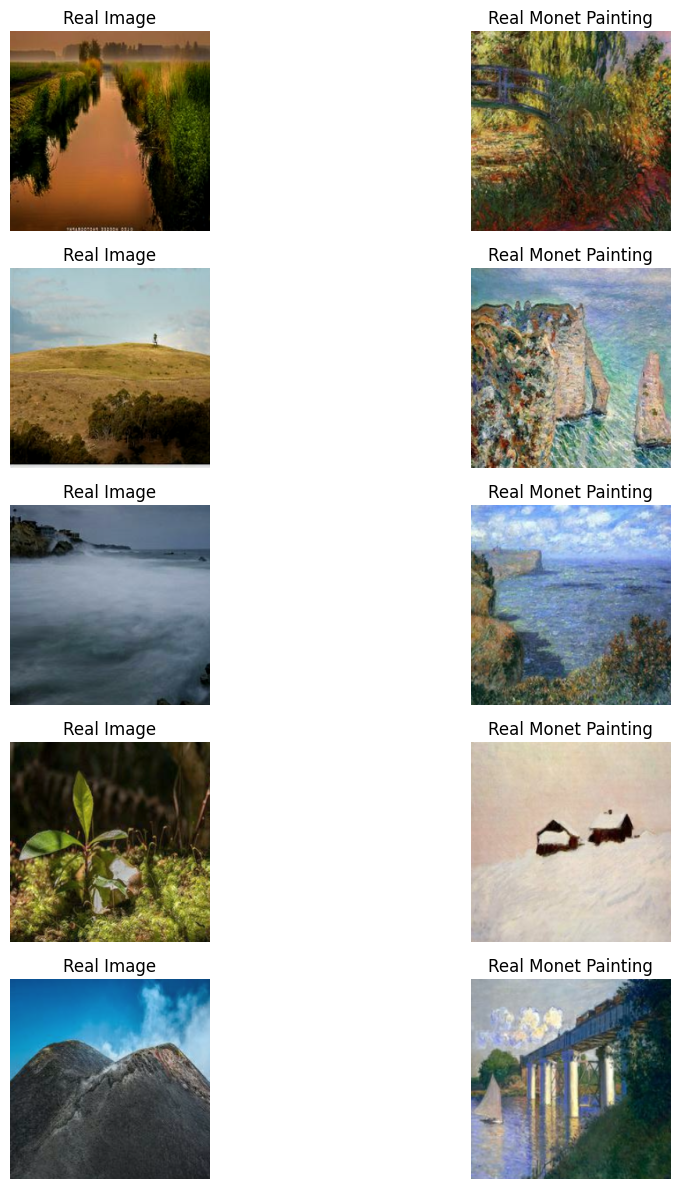

In [11]:
def denorm(x):
    return (x + 1.0) / 2.0

def show_monet_regular(photo_ds, monet_ds, num=5):
    regular_iter = iter(photo_ds)
    monet_iter = iter(monet_ds)
    plt.figure(figsize=(12, 12))

    for i in range(num):
        regular_batch = next(regular_iter)
        monet_batch = next(monet_iter)
        regular = regular_batch[0]
        monet = monet_batch[0]
        regular = denorm(regular)
        monet = denorm(monet)

        ax = plt.subplot(num, 2, 2*i + 1)
        plt.imshow(regular.numpy())
        plt.title("Real Image")
        plt.axis("off")

        ax = plt.subplot(num, 2, 2*i + 2)
        plt.imshow(monet.numpy())
        plt.title("Real Monet Painting")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_monet_regular(photo_ds, monet_ds, num = 5)

### Step 2.7: Plan of Analysis given EDA
Given the histogram plot of brightness and RGB channel distribution there exist significant domain shifts between the regular images and the Monet paintings - which makes sense. I order to assist in the generalization of the model and in generating 7000 monet style images, the images have been preprocessed according the insights gained from the EDA. Specifically, random jittering was applied to both the Monet's and regular images, and photometric augmentations including gamma augmentations were applied to the regular images in order to broaden the spectrum of images to be fed into the CycleGAN and assist in achieved the required domain shift. 

## Step 3: Building & Analyzing Model Architecture
#### Model Architecture Breakdown
The code implement a CycleGAN architecture with U-Net-based generators and PatchGan-Style discriminators for translating regular photos into Monet-Style paintings. 

1. Instance Normalization
   - Used instead of BatchNorm because it normalizes each individual image channel-wise, not across the batch.
   - The is suitable for transfer tasks where preserving instance-specific content and style ddetials is more important than generalizing across a batch.
2. Downsampling and Upsamling Blocks
   - Downsample: A convolutional block with Conv2D and stride of 2 for spatial downsampling and LeakyRelu. It capture lower-level features and compresses the image spatially.
   - Upsample: A transpose convulutional block with stride of 2 for upsampling and ReLU. It reconstructs the image while allowing learned transformations
3. Generator: U-Net
   - Encoder-Decoder structure with skip connections. The skip connections allow the detailed low-level features to bypass bottlenecks which is important for maintaining photorealistic structure.
4. Discriminator: PatchGAN
   - Uses convolutional layers that output a grid of real/fake predictions. Each output element corresponds to a small patch of the input. This makes it less memory-intensive than full-image discriminators.
5. Loss Functions:
   - Generator Loss (g_loss): Binary Cross-Entropy against real labels to encourage the generator to fool the discriminator
   - Discriminator Loss (d_loss): discriminates between real and generated images using BCE
   - Cycle Consistency Loss (cycle_loss): Ensures that G(F(x)) ≈ x and F(G(y)) ≈ y
   - Identity Loss: Encourages that G(y) ≈ y and F(x) ≈ x when the input is already in the target domain and thereby prevents over-stylization

The CycleGAN Framework is ideal for unpaired image translation, hence when there do not exist photo - monet pairs but rather the images are independent of one-another as is the case in this dataset. 

In [8]:
# InstanceNorm
class InstanceNorm(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.eps = epsilon

    def build(self, input_shape):
        channels = input_shape[-1]
        self.scale = self.add_weight(
            name="scale",
            shape=(channels,),
            initializer=tf.random_normal_initializer(0., 0.02),
            trainable=True,
        )
        self.offset = self.add_weight(
            name="offset",
            shape=(channels,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.scale * (x - mean) * tf.math.rsqrt(var + self.eps) + self.offset

# Downsample / Upsample blocks
def downsample(filters, size, apply_instancenorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    layers = [tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                     kernel_initializer=init, use_bias=False)]
    if apply_instancenorm:
        layers.append(InstanceNorm())
    layers.append(tf.keras.layers.LeakyReLU(0.2))
    return tf.keras.Sequential(layers)

def upsample(filters, size, apply_instancenorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    layers = [tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                              kernel_initializer=init, use_bias=False)]
    if apply_instancenorm:
        layers.append(InstanceNorm())
    layers.append(tf.keras.layers.ReLU())
    return tf.keras.Sequential(layers)

# Generator: U-Net
def unet_generator(output_channels=3):
    inputs = tf.keras.Input(shape=[256, 256, 3])
    skips = []
    x = inputs

    for filters in [64, 128, 256, 512, 512, 512, 512, 512]:
        x = downsample(filters, 4, apply_instancenorm=(filters != 64))(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for filters, skip in zip([512, 512, 512, 512, 256, 128, 64], skips):
        x = upsample(filters, 4)(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Discriminator
def build_discriminator():
    inp = tf.keras.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, 2, padding='same')(inp)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    for filters in [128, 256, 512]:
        x = tf.keras.layers.Conv2D(filters, 4, 2 if filters != 512 else 1, padding='same', use_bias=False)(x)
        x = InstanceNorm()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
    out = tf.keras.layers.Conv2D(1, 4, 1, padding='same')(x)
    return tf.keras.Model(inputs=inp, outputs=out)

# Loss Functions
def d_loss(real, fake):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return 0.5 * (bce(tf.ones_like(real), real) + bce(tf.zeros_like(fake), fake))

def g_loss(fake):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(fake), fake)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same))

# Training Step
def make_train_step(G, F, DX, DY, G_opt, F_opt, DX_opt, DY_opt, lambda_cycle=10.0, lambda_id=5.0):
    @tf.function
    def train_step(real_photo, real_monet):
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = G(real_photo, training=True)
            fake_photo = F(real_monet, training=True)
            cycled_photo = F(fake_monet, training=True)
            cycled_monet = G(fake_photo, training=True)
            same_photo = F(real_photo, training=True)
            same_monet = G(real_monet, training=True)

            disc_real_photo = DY(real_photo, training=True)
            disc_fake_photo = DY(fake_photo, training=True)
            disc_real_monet = DX(real_monet, training=True)
            disc_fake_monet = DX(fake_monet, training=True)

            G_adv = g_loss(disc_fake_monet)
            F_adv = g_loss(disc_fake_photo)
            cyc_loss = cycle_loss(real_photo, cycled_photo) + cycle_loss(real_monet, cycled_monet)
            id_loss = identity_loss(real_photo, same_photo) + identity_loss(real_monet, same_monet)
            G_total = G_adv + lambda_cycle * cyc_loss + lambda_id * id_loss
            F_total = F_adv + lambda_cycle * cyc_loss + lambda_id * id_loss
            DX_total = d_loss(disc_real_monet, disc_fake_monet)
            DY_total = d_loss(disc_real_photo, disc_fake_photo)

        G_grads = tape.gradient(G_total, G.trainable_variables)
        F_grads = tape.gradient(F_total, F.trainable_variables)
        DX_grads = tape.gradient(DX_total, DX.trainable_variables)
        DY_grads = tape.gradient(DY_total, DY.trainable_variables)

        G_opt.apply_gradients(zip(G_grads, G.trainable_variables))
        F_opt.apply_gradients(zip(F_grads, F.trainable_variables))
        DX_opt.apply_gradients(zip(DX_grads, DX.trainable_variables))
        DY_opt.apply_gradients(zip(DY_grads, DY.trainable_variables))

        return G_total, F_total, DX_total, DY_total, cyc_loss
    return train_step

## Step 4: Hyperparameter Tuning
The goal of the following hyperparameter tuning procedure is to find the lowest average cycle consistency loss - this is a proxy for how well the generated images retain structure while adapting style. It finds a combination of the following hyperparameters: 
- lambda_cycle: weight for the cycle consistency loss
- lambda_id: weights for the identity loss (helps prevent over-stylization)
- lr: learning rate for the Adam optimizer
- beta1: momentum term for Adam which affects convergence

Five independent trials are run, each with 7 epochs and a random set of hyperparameter values. 

Moreover, to reduce inference time only 20% of the origial photo and monet datasets were used to run the trials. 

Subsequently, a bar plot is displayed showing the average cylce loss per trial. The lowest bar indicates highest performance. Finally, the best configuration of values is saved and printed. 

Trial 1: score=0.2936, config={'lambda_cycle': 10.0, 'lambda_id': 5.0, 'lr': 0.0002, 'beta1': 0.5}


Trial 2: score=0.3183, config={'lambda_cycle': 10.0, 'lambda_id': 2.5, 'lr': 0.0002, 'beta1': 0.9}


Trial 3: score=0.2976, config={'lambda_cycle': 15.0, 'lambda_id': 2.5, 'lr': 0.0002, 'beta1': 0.5}


Trial 4: score=0.3648, config={'lambda_cycle': 5.0, 'lambda_id': 2.5, 'lr': 0.0001, 'beta1': 0.5}


Trial 5: score=0.3699, config={'lambda_cycle': 5.0, 'lambda_id': 7.5, 'lr': 0.0001, 'beta1': 0.5}


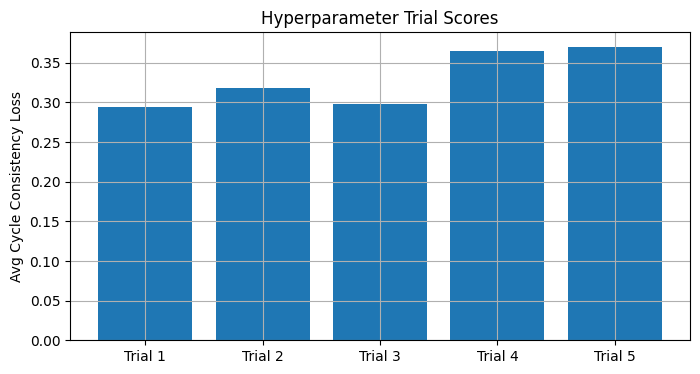

Best hyperparameter configuration: {'lambda_cycle': 10.0, 'lambda_id': 5.0, 'lr': 0.0002, 'beta1': 0.5}


In [27]:
def run_trial(photo_ds, monet_ds, lambda_cycle, lambda_id, lr, beta1, epochs=7, trial_id=0):
    G = unet_generator()
    F = unet_generator()
    DX = build_discriminator()
    DY = build_discriminator()

    G_opt = tf.keras.optimizers.Adam(lr, beta_1=beta1)
    F_opt = tf.keras.optimizers.Adam(lr, beta_1=beta1)
    DX_opt = tf.keras.optimizers.Adam(lr, beta_1=beta1)
    DY_opt = tf.keras.optimizers.Adam(lr, beta_1=beta1)

    train_step = make_train_step(G, F, DX, DY, G_opt, F_opt, DX_opt, DY_opt, lambda_cycle, lambda_id)

    steps_per_epoch = min(len(photo_ds), len(monet_ds)) // BATCH_SIZE
    cycle_losses = []

    for epoch in range(epochs):
        epoch_cycle_loss = 0.0
        pbar = tqdm(tf.data.Dataset.zip((photo_ds, monet_ds)).take(steps_per_epoch),
                    desc=f"Trial {trial_id+1} | Epoch {epoch+1}/{epochs}", leave=False)
        for photo_batch, monet_batch in pbar:
            _, _, _, _, cyc = train_step(photo_batch, monet_batch)
            epoch_cycle_loss += cyc.numpy()
            pbar.set_postfix({"CycleLoss": f"{cyc.numpy():.4f}"})
        cycle_losses.append(epoch_cycle_loss / steps_per_epoch)

    return sum(cycle_losses) / len(cycle_losses)


results = []
search_space = {
    "lambda_cycle": [5.0, 10.0, 15.0],
    "lambda_id": [2.5, 5.0, 7.5],
    "lr": [1e-4, 2e-4],
    "beta1": [0.5, 0.9]
}

TRIALS = 5

for i in range(TRIALS):
    config = {k: random.choice(v) for k, v in search_space.items()}
    score = run_trial(photo_ds_tune, monet_ds_tune, **config, trial_id=i)
    results.append((config, score))
    print(f"Trial {i+1}: score={score:.4f}, config={config}")

# Plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(results)), [r[1] for r in results])
plt.xticks(range(len(results)), [f"Trial {i+1}" for i in range(len(results))])
plt.ylabel("Avg Cycle Consistency Loss")
plt.title("Hyperparameter Trial Scores")
plt.grid(True)
plt.show()

# Best config
best_config = min(results, key=lambda x: x[1])[0]
print("Best hyperparameter configuration:", best_config)


The barplot above shows that the lowest cycle loss was achieved by the combination of values used for trial 1. 

Certainly, a more exhaustive search could have been performed but for the purpose of this exploration the plot with just 5 trials highlights that tuning is a necessity. GANs are notoriously unstable and strongly affected by hyperparameter values. Also a larger search space could have been chosen. 

If the goal of this exploration were to develop the best possible CycleGAN model then I would have performed the following tuning procedure: 
- Large search space
- 30-50 Epochs per trial as a baseline but with early stopping implemented
- 100 trials
- Used the entirety of the datasets, not just 20%

In the following section the CycleGAN will be trained with the best combination of hyperparameter values found in order to benefit from the tuning step. 

## Step 5: Training on Best Hyperparameters

In [ ]:
best_config = {'lambda_cycle': 10.0, 'lambda_id': 5.0, 'lr': 0.0002, 'beta1': 0.5}

G = unet_generator()
F = unet_generator()
DX = build_discriminator()
DY = build_discriminator()

G_opt = tf.keras.optimizers.Adam(best_config["lr"], beta_1=best_config["beta1"])
F_opt = tf.keras.optimizers.Adam(best_config["lr"], beta_1=best_config["beta1"])
DX_opt = tf.keras.optimizers.Adam(best_config["lr"], beta_1=best_config["beta1"])
DY_opt = tf.keras.optimizers.Adam(best_config["lr"], beta_1=best_config["beta1"])

train_step = make_train_step(G, F, DX, DY, G_opt, F_opt, DX_opt, DY_opt,
                             best_config["lambda_cycle"], best_config["lambda_id"])

steps_per_epoch = min(len(photo_images), len(monet_images)) // BATCH_SIZE
history = {"G_total": [], "F_total": [], "DX_loss": [], "DY_loss": []}

for epoch in range(EPOCHS):
    g_sum = f_sum = dx_sum = dy_sum = 0.0
    pbar = tqdm(tf.data.Dataset.zip((photo_ds, monet_ds)).take(steps_per_epoch),
                desc=f"Epoch {epoch+1}/50", leave=False)

    for real_photo_batch, real_monet_batch in pbar:
        G_t, F_t, DX_t, DY_t, _ = train_step(real_photo_batch, real_monet_batch)
        g_sum += G_t.numpy()
        f_sum += F_t.numpy()
        dx_sum += DX_t.numpy()
        dy_sum += DY_t.numpy()
        pbar.set_postfix({
            "G": f"{G_t.numpy():.2f}", "F": f"{F_t.numpy():.2f}",
            "DX": f"{DX_t.numpy():.2f}", "DY": f"{DY_t.numpy():.2f}"
        })

    history['G_total'].append(g_sum / steps_per_epoch)
    history['F_total'].append(f_sum / steps_per_epoch)
    history['DX_loss'].append(dx_sum / steps_per_epoch)
    history['DY_loss'].append(dy_sum / steps_per_epoch)

    print(f"Epoch {epoch+1}: G={history['G_total'][-1]:.3f}, "
          f"F={history['F_total'][-1]:.3f}, "
          f"DX={history['DX_loss'][-1]:.3f}, "
          f"DY={history['DY_loss'][-1]:.3f}")

# Save Models
G.save("G_final.h5")
F.save("F_final.h5")
DX.save("DX_final.h5")
DY.save("DY_final.h5")

Epoch 1/50:   0%|          | 0/300 [00:00<?, ?it/s]I0000 00:00:1753796406.674245      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1: G=5.642, F=5.552, DX=0.590, DY=0.632


Epoch 2: G=3.742, F=3.677, DX=0.615, DY=0.630


Epoch 3: G=3.347, F=3.322, DX=0.636, DY=0.646


Epoch 4: G=3.140, F=3.116, DX=0.622, DY=0.628


Epoch 5: G=3.080, F=3.057, DX=0.613, DY=0.619


Epoch 6: G=3.049, F=3.041, DX=0.621, DY=0.612


Epoch 7: G=2.959, F=2.942, DX=0.608, DY=0.612


Epoch 8: G=2.916, F=2.915, DX=0.620, DY=0.617


Epoch 9: G=2.855, F=2.875, DX=0.622, DY=0.610


Epoch 10: G=2.845, F=2.880, DX=0.614, DY=0.600


Epoch 11: G=2.859, F=2.886, DX=0.614, DY=0.602


Epoch 12: G=2.836, F=2.870, DX=0.621, DY=0.606


Epoch 13: G=2.772, F=2.801, DX=0.610, DY=0.599


Epoch 14: G=2.839, F=2.874, DX=0.615, DY=0.600


Epoch 15: G=2.778, F=2.832, DX=0.619, DY=0.583


Epoch 16: G=2.745, F=2.816, DX=0.633, DY=0.603


Epoch 17/50:  91%|█████████▏| 274/300 [01:08<00:06,  4.02it/s, G=2.43, F=2.56, DX=0.70, DY=0.62]

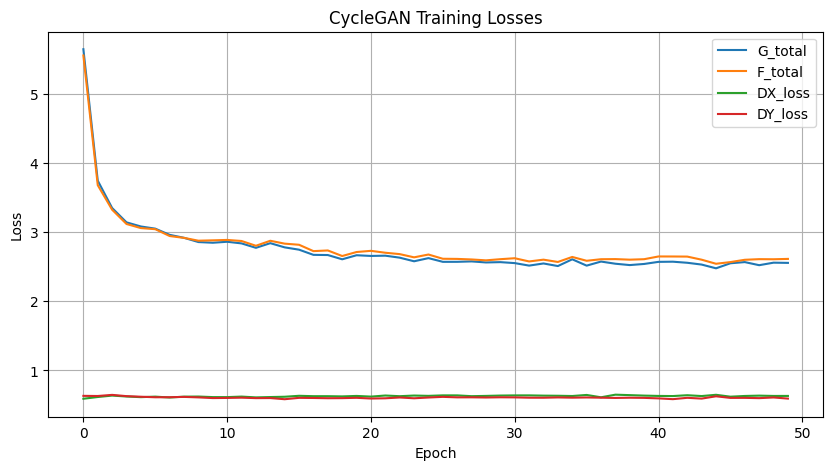

In [13]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(history['G_total'], label="G_total")
plt.plot(history['F_total'], label="F_total")
plt.plot(history['DX_loss'], label="DX_loss")
plt.plot(history['DY_loss'], label="DY_loss")
plt.title("CycleGAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Step 5.1: Analysis of Training Losses
- G_total and F_total: both generator losses drop steeply, indicating fast early learning. They then gradually stabilize around the 20-25 Epoch mark. Also they show close alignment throughout, which suggests balanced training between the two translation direction.
- DX_loss and DY_loss: Both losses are consistently low with now significant spike or divergence.

Overall there is no sign of mode collapse or instability. 

### Step 5.2: Training Improvements
Given that the losses for the generator plateaued it would have made sense to implement early stopping. One could also consider reducing the learning rate after 20 or so epochs or implement learning rate scheduling. 

### Step 5.1: Show a Couple Pairs of Original and Generated Monet-Style Images
The following code displays 5 regular images and their monet style counterparts. This step aids in visual inspection. 

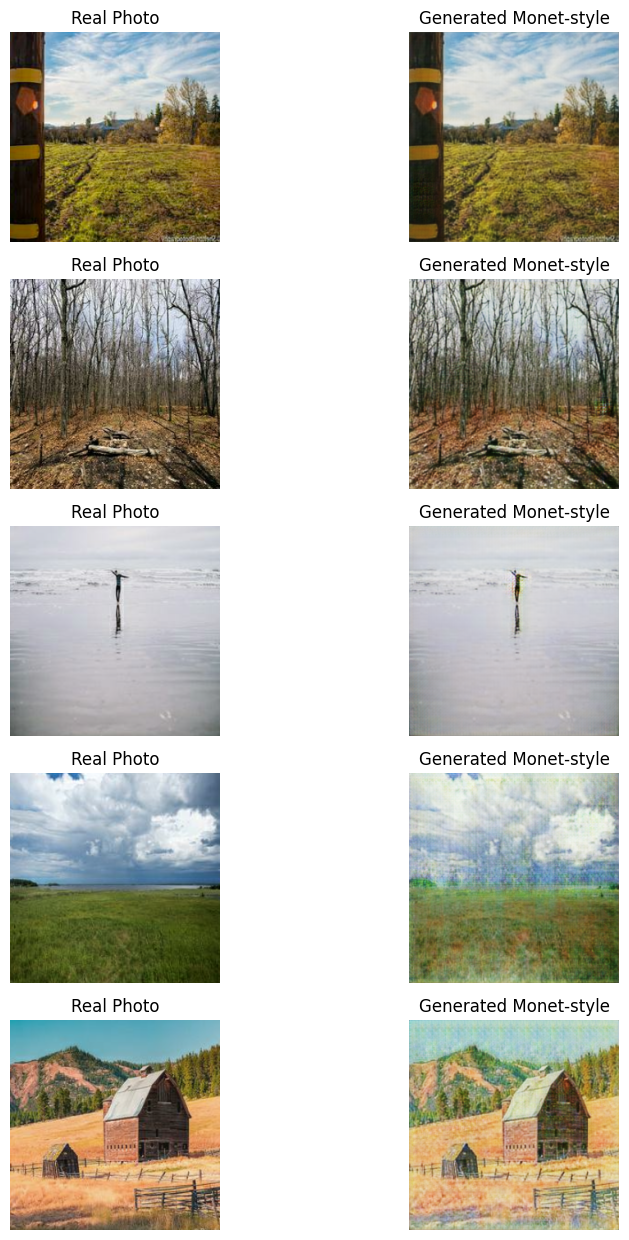

In [14]:
# Load the trained generator model
#G = load_model("G_final.h5", custom_objects={"InstanceNorm": InstanceNorm})

# Convert from [-1, 1] to [0, 1]
def denormalize(img):
    return (img + 1.0) / 2.0

# Forward pass using the trained generator
def generate_monet(generator_G, photo_batch):
    return generator_G(photo_batch, training=False)

# Display real photos and their Monet-style counterparts
def show_generated_images(generator_G, photo_dataset, num_images=5):
    plt.figure(figsize=(10, num_images * 2.5))
    count = 0

    for photo_batch in photo_dataset:
        for j in range(photo_batch.shape[0]):
            if count >= num_images:
                break
            photo = photo_batch[j:j+1]  # keep batch dimension
            generated = generate_monet(generator_G, photo)[0]  # remove batch dimension

            photo_disp = denormalize(photo[0]).numpy()
            gen_disp = denormalize(generated).numpy()

            # Real Photo
            ax = plt.subplot(num_images, 2, 2 * count + 1)
            plt.imshow(photo_disp)
            plt.title("Real Photo")
            plt.axis("off")

            # Generated Monet-style
            ax = plt.subplot(num_images, 2, 2 * count + 2)
            plt.imshow(gen_disp)
            plt.title("Generated Monet-style")
            plt.axis("off")

            count += 1
        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()

show_generated_images(G, photo_ds, num_images=5)

## Step 6: Generate 7000 Monet-Style Images and Save as Zip
The following code uses the trained generator G to generate 7000 monet-style images. The images are then saved in a zipped folder as it required by kaggle to evaluate the images according to their MiFID score. 

In [15]:
# Load the trained generator model
#G = load_model("G_final.h5", custom_objects={"InstanceNorm": InstanceNorm})

image_folder = "/kaggle/working/images"
zip_path = "/kaggle/working/images.zip"
os.makedirs(image_folder, exist_ok=True)

def denormalize_for_save(img_tensor):
    img = (img_tensor + 1.0) / 2.0  # [-1,1] -> [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = tf.image.convert_image_dtype(img, tf.uint8)  # [0,1] -> uint8
    return img
    
def save_generated_images(generator_G, photo_dataset, output_dir, num_images=NUM_TO_GENERATE):
    saved_count = 0
    for batch in tqdm(photo_dataset, desc="Generating and saving images"):
        generated_batch = generator_G(batch, training=False)
        for i in range(generated_batch.shape[0]):
            if saved_count >= num_images:
                return
            gen_img = denormalize_for_save(generated_batch[i])
            img = Image.fromarray(gen_img.numpy())
            img.save(os.path.join(output_dir, f"monet_{saved_count+1:05d}.jpg"))
            saved_count += 1

save_generated_images(G, photo_ds, image_folder, num_images=7000)

def zip_folder(folder_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=folder_path)
                z.write(file_path, arcname=arcname)

zip_folder(image_folder, zip_path)
print(f"Zipped images saved to: {zip_path}")


Generating and saving images:  99%|█████████▉| 7000/7038 [05:26<00:01, 21.47it/s]


Zipped images saved to: /kaggle/working/images.zip


## Step 7: Discussion and Conclusion

After generating 7000 monet-style images and submitting it via the Kaggle competition I achieved a MiFID score of 59.33570 and am currently ranked 35th out of 144 on the leaderboard (see image below)

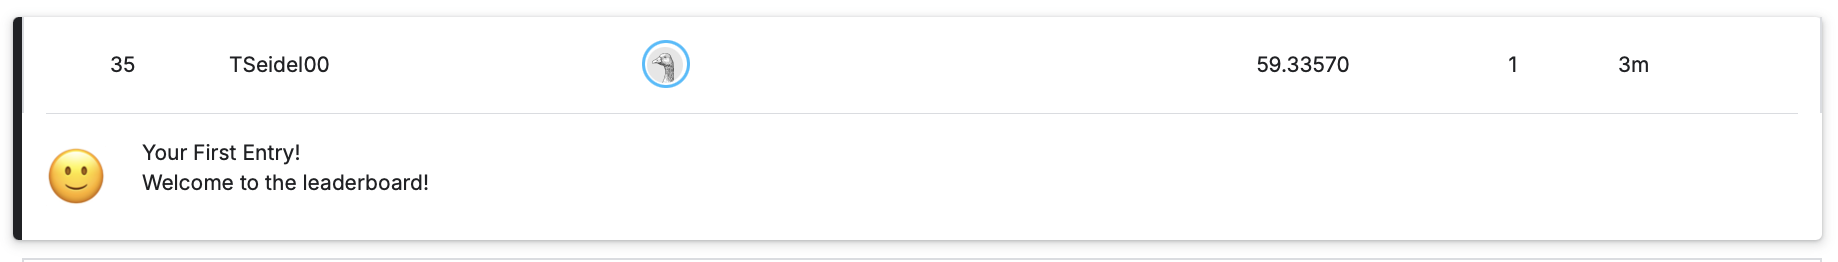

##### MiFID (Memorization-informed Fréchet Inception Distance
This metric is a variant of FID that: 
- Measures the distance between feature distributions of generated images and in this case real monet images
- It penalizes models that memorize training examples
- Lowers scores indicate a closer match to Monet style, while preserving diversity and avoiding memorization.

##### Interpretation of Score: 59.34
An MiFID score of 59 is moderate. My model produces Monet-Like images as can be seen in step 5.1 but there exists a gap in terms of realism, diversity, or perhaps memorization avoidance. Each image would have to be compared to identify whether the moderate score resulted from memorization or from a lack of realism. 

##### Ideas for Improvement
In order to further improve training stability I could have implemented learning rate decay, adaptive loss weights or exponential moving averages of generator weights. 

Also I could improve upon the model architecture by doing the following: 
- Use ResNet-based generators such as CycleGAN v2
- Employ Attention mechanisms
- Swap U-Net with ResNet9 for example
- Implement a more exhaustive hyperparameter tuning as suggested in Step 4.

##### Conclusion
The result shows solid progress and lays the groundwork. There is room to narrow the distribution gap. 
